In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE

In [16]:
data = pd.read_csv("cleaned_data.csv")

In [20]:
data["Years of Credit History"].iloc[12]

36.6

In [18]:
loan_id_mapping = {id: index for index, id in enumerate(data['Loan ID'].unique())}
customer_id_mapping = {id: index for index, id in enumerate(data['Customer ID'].unique())}

# Replace the IDs with the mapped integers
data['Loan ID'] = data['Loan ID'].map(loan_id_mapping)
data['Customer ID'] = data['Customer ID'].map(customer_id_mapping)

employment_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

data['Years in current job'] = data['Years in current job'].map(employment_length_mapping)
data['Years of Credit History'] = data['Years of Credit History'].apply(lambda x: float(''.join(c if c.isdigit() or c == '.' else ' ' for c in x).strip()))
data['Monthly Debt'] = data['Monthly Debt'].apply(lambda x: float(''.join(c if c.isdigit() or c == '.' else ' ' for c in x).strip()))


In [4]:
# Define target variable (y) and other varibles (X)
y = data['Loan Status']
X = data.drop(['Loan Status', "Loan ID", "Customer ID"], axis = 1)

# Split dataset
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

# Show the data split in numbers
shape_dict = {'shape of whole dataset': data.shape, 'shape of train_X': train_X.shape, 'shape of test_X': test_X.shape, 'shape of train_y': train_y.shape, 'shape of test_y': test_y.shape}
for i, v in shape_dict.items(): 
    print(i, v)

shape of whole dataset (20371, 19)
shape of train_X (13648, 16)
shape of test_X (6723, 16)
shape of train_y (13648,)
shape of test_y (6723,)


In [5]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
smote_X, smote_y = sm.fit_resample(train_X, train_y)

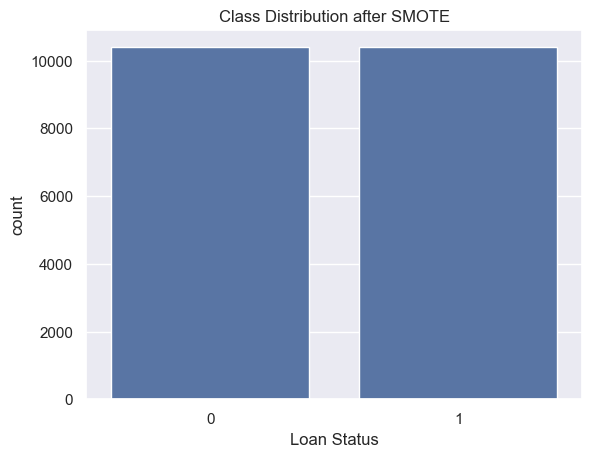

In [6]:
smote_y.value_counts()

# Visualize the resampled class distribution after SMOTE
sns.countplot(x=smote_y)
plt.title("Class Distribution after SMOTE")
plt.show()

# Logistic Regression

In [7]:
clf = LogisticRegression(solver = 'liblinear', random_state=42)
clf.fit(smote_X, smote_y)
pred_y = clf.predict(test_X)
pred_proba_y = clf.predict_proba(test_X)

In [8]:
# Examine the coefficients (the predicted probabilities)
coef = clf.coef_
print(coef)

[[ 6.76553285e-07 -4.99035202e-05  1.10697431e-03 -8.83613358e-07
  -1.26886767e-03 -2.57807764e-04 -2.54624919e-04  1.29502913e-05
  -5.10250577e-04 -6.56642287e-03 -1.20383734e-03 -9.98213111e-05
   7.32114414e-07 -4.75057245e-07 -2.27413560e-05  7.65972170e-06]]


In [9]:
coef_titles = list(X.columns)
coef = pd.DataFrame(clf.coef_.T, columns=['coefficients'], index=coef_titles)
coef

,coefficients
Current Loan Amount,6.765533e-07
Term,-4.990352e-05
Credit Score,1.106974e-03
Annual Income,-8.836134e-07
Years in current job,-1.268868e-03
Home Ownership,-2.578078e-04
Purpose,-2.546249e-04
Monthly Debt,1.295029e-05
Years of Credit History,-5.102506e-04
Months since last delinquent,-6.566423e-03


In [10]:
probability_of_class_1 = pred_proba_y[:, 1]

print("Predicted probability of class 1:", probability_of_class_1)

Predicted probability of class 1: [0.41032234 0.41912042 0.32642025 ... 0.4649432  0.9985988  0.56572642]


In [11]:
print("Classifcation report:\n", classification_report(test_y, pred_y))
print("Confusion matrix:\n", confusion_matrix(test_y, pred_y))


Classifcation report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78      5153
           1       0.38      0.52      0.44      1570

    accuracy                           0.69      6723
   macro avg       0.61      0.63      0.61      6723
weighted avg       0.73      0.69      0.70      6723

Confusion matrix:
 [[3791 1362]
 [ 749  821]]


In [12]:
data["Loan Status"].value_counts()

Loan Status
0    15546
1     4825
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

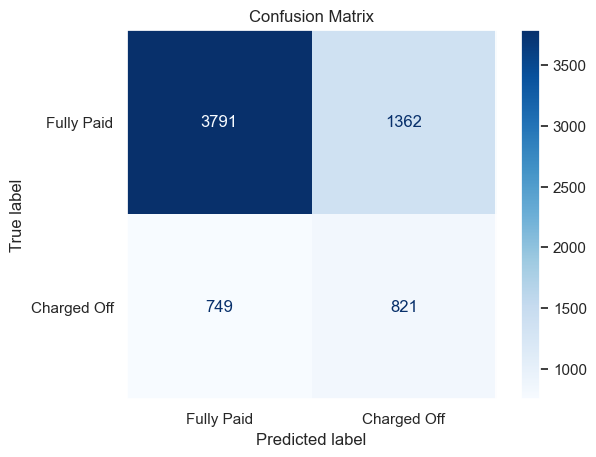

<Figure size 1000x600 with 0 Axes>

In [13]:
cm = confusion_matrix(test_y, pred_y)


labels = ['Fully Paid', 'Charged Off']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.figure(figsize = (10,6))

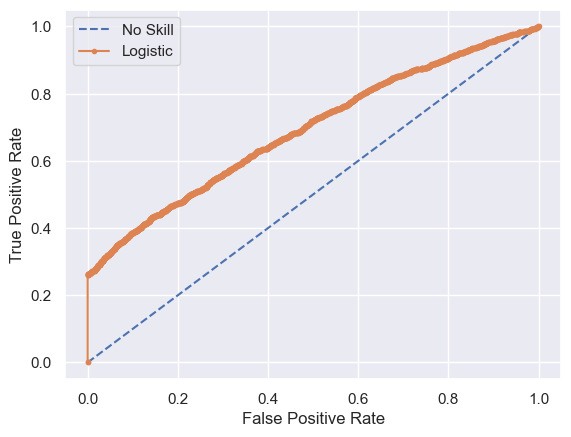

In [14]:
#ROC curve
from sklearn.metrics import roc_curve
from matplotlib import pyplot
pred_proba_y = pred_proba_y[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, pred_proba_y)
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

In [15]:
from sklearn.metrics import roc_auc_score 
auc = roc_auc_score(test_y, pred_proba_y)

auc

0.6919695533243265

In [16]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(smote_X, smote_y)
pred_y = dt.predict(test_X)
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      5153
           1       0.39      0.50      0.44      1570

    accuracy                           0.70      6723
   macro avg       0.61      0.63      0.62      6723
weighted avg       0.73      0.70      0.72      6723



In [18]:
print(confusion_matrix(test_y, pred_y))

[[3949 1204]
 [ 785  785]]


<Figure size 1000x600 with 0 Axes>

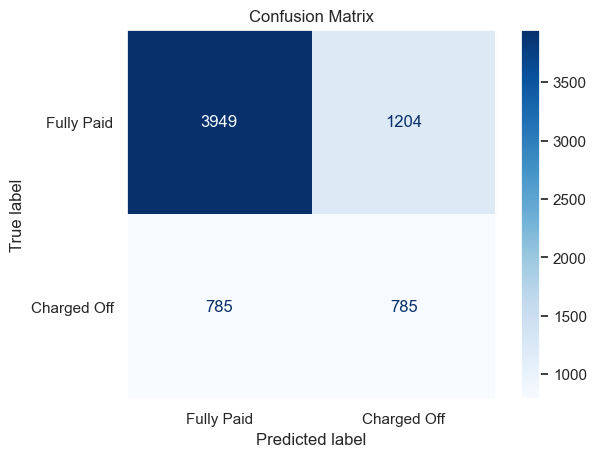

<Figure size 1000x600 with 0 Axes>

In [19]:
cm = confusion_matrix(test_y, pred_y)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['Fully Paid', 'Charged Off']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.figure(figsize = (10,6))

[Ellipsis]

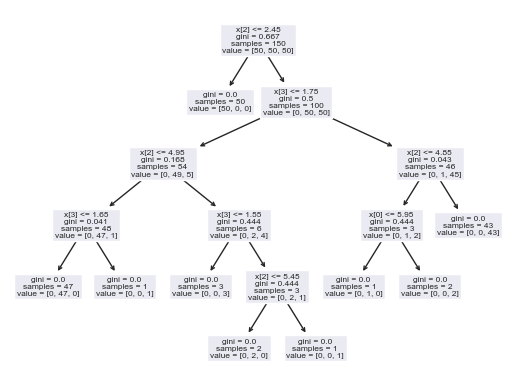

In [23]:
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(X, y)

tree.plot_tree(clf)
[...]

In [24]:
rf = RandomForestClassifier(random_state=42)
rf.fit(smote_X, smote_y)
pred_y = rf.predict(test_X)
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      5153
           1       0.62      0.35      0.45      1570

    accuracy                           0.80      6723
   macro avg       0.72      0.64      0.66      6723
weighted avg       0.78      0.80      0.78      6723



In [25]:
print(confusion_matrix(test_y, pred_y))

[[4825  328]
 [1025  545]]


<Figure size 1000x600 with 0 Axes>

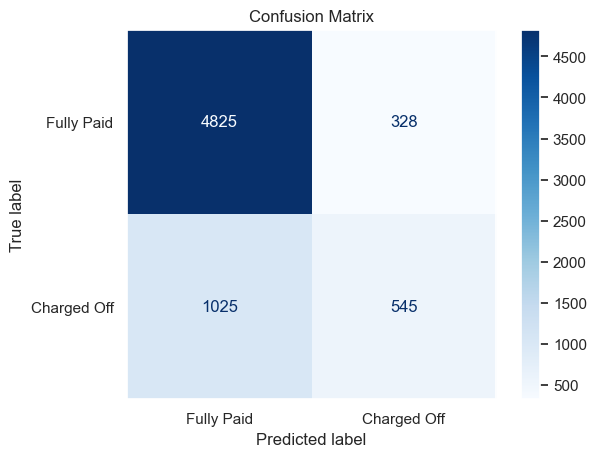

<Figure size 1000x600 with 0 Axes>

In [26]:
cm = confusion_matrix(test_y, pred_y)
labels = ['Fully Paid', 'Charged Off']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.figure(figsize = (10,6))

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, test_X, test_y, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()



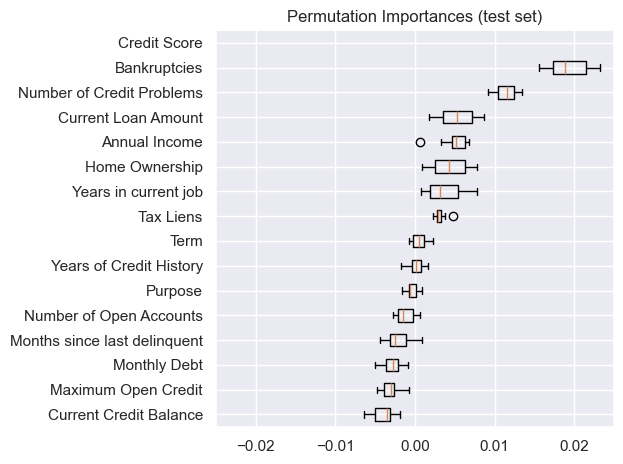

In [45]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=test_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
#set xtics to 0.1
plt.xlim(-0.025, 0.025)
fig.tight_layout()